In [ ]:
!pip install pandas
!pip install transformers
!pip install torch
!pip install torchvision

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
import os
from transformers import AdamW

def read_texts_from_directory(directory):
    texts = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                text = file.read()
                texts.append(text)
    return texts

# Veri yolları (fine-tuning için)
fake_news_dir = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/90-train/fake'
real_news_dir = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/90-train/real'

# Yüklenen modelin ve konfigürasyonun yolunu belirttim
config_path = '/content/drive/MyDrive/collab1/DOSYALAR/bertdataset_teslim4/config.json'
model_path = '/content/drive/MyDrive/collab1/DOSYALAR/bertdataset_teslim4/model.safetensors'

# Modelin ve konfigürasyonun yüklenmesi
config = DistilBertConfig.from_json_file(config_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path, config=config)
# Donmuş katmanları ayarlama
for param in model.distilbert.parameters():
    param.requires_grad = False
# Tokenizer kısmı
tokenizer = DistilBertTokenizer.from_pretrained('dbmdz/distilbert-base-turkish-cased', truncation=True, padding=True)

# Veri setini oluşturma
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Veri kümesini oluşturma
# Fake ve real haber metinlerini okudum
fake_texts = read_texts_from_directory(fake_news_dir)
real_texts = read_texts_from_directory(real_news_dir)
labels = [0] * len(fake_texts) + [1] * len(real_texts)  # 0: fake, 1: real

# Veri kümesini train ve test olarak ayırdım
train_texts, test_texts, train_labels, test_labels = train_test_split(
    fake_texts + real_texts, labels, test_size=0.1, random_state=42
)

# Veri setlerini oluşturma
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=128)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_len=128)

# Optimizer ve loss fonksiyonunu tanımlama
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

# DataLoader'ları oluşturma kısmı
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Device belirleme kısmı
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Fine-tuning işlemi
epochs = 3

for epoch in range(epochs):
    model.train()
    epoch_loss = 0  # Bu değişken toplam kayıp değerini tutar
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        # Toplam kayıp için loss.item() kullanarak kayıp değerini hesapladım
        epoch_loss += loss.item() * input_ids.size(0)  # Toplam kayıp
    avg_train_loss = epoch_loss / len(train_dataset)  # Ortalama kayıp
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}')

    # Modelin başarı oranını test etme
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    print(f'Epoch {epoch + 1}/{epochs}, Accuracy: {accuracy}')

# Fine-tuning sonrası modeli kaydet
model.save_pretrained('/content/drive/MyDrive/collab1/DOSYALAR/fine_tuned_modelhoca')
'''
100%|██████████| 985/985 [01:01<00:00, 15.92it/s]
100%|██████████| 110/110 [00:08<00:00, 12.98it/s]
Epoch 1/3, Accuracy: 0.9748858447488584
100%|██████████| 985/985 [00:59<00:00, 16.68it/s]
100%|██████████| 110/110 [00:08<00:00, 13.36it/s]
Epoch 2/3, Accuracy: 0.9874429223744292
100%|██████████| 985/985 [00:57<00:00, 17.11it/s]
100%|██████████| 110/110 [00:07<00:00, 15.12it/s]
Epoch 3/3, Accuracy: 0.9897260273972602

'''

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/410 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 985/985 [01:17<00:00, 12.66it/s]


Epoch 1/3, Training Loss: 0.2312287937651204


100%|██████████| 110/110 [00:08<00:00, 13.55it/s]


Epoch 1/3, Accuracy: 0.9794520547945206


100%|██████████| 985/985 [01:13<00:00, 13.46it/s]


Epoch 2/3, Training Loss: 0.1015507046788633


100%|██████████| 110/110 [00:08<00:00, 12.65it/s]


Epoch 2/3, Accuracy: 0.9748858447488584


100%|██████████| 985/985 [01:13<00:00, 13.43it/s]


Epoch 3/3, Training Loss: 0.08221979806108665


100%|██████████| 110/110 [00:08<00:00, 12.31it/s]


Epoch 3/3, Accuracy: 0.9851598173515982


'\n100%|██████████| 985/985 [01:01<00:00, 15.92it/s]\n100%|██████████| 110/110 [00:08<00:00, 12.98it/s]\nEpoch 1/3, Accuracy: 0.9748858447488584\n100%|██████████| 985/985 [00:59<00:00, 16.68it/s]\n100%|██████████| 110/110 [00:08<00:00, 13.36it/s]\nEpoch 2/3, Accuracy: 0.9874429223744292\n100%|██████████| 985/985 [00:57<00:00, 17.11it/s]\n100%|██████████| 110/110 [00:07<00:00, 15.12it/s]\nEpoch 3/3, Accuracy: 0.9897260273972602\n\n'

EARLY STOPPİNG EKLENMİŞ HALİ

In [ ]:
from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
import os
from transformers import AdamW

def read_texts_from_directory(directory):
    texts = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                text = file.read()
                texts.append(text)
    return texts

# Veri yolları (fine-tuning için)
fake_news_dir = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/90-train/fake'
real_news_dir = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/90-train/real'

# Yüklenen modelin ve konfigürasyonun yolunu belirttim
config_path = '/content/drive/MyDrive/collab1/DOSYALAR/bertdataset_teslim4/config.json'
model_path = '/content/drive/MyDrive/collab1/DOSYALAR/bertdataset_teslim4/model.safetensors'

# Modelin ve konfigürasyonun yüklenmesi
config = DistilBertConfig.from_json_file(config_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path, config=config)

# Donmuş katmanları ayarlama
for param in model.distilbert.parameters():
    param.requires_grad = False

# Tokenizer kısmı
tokenizer = DistilBertTokenizer.from_pretrained('dbmdz/distilbert-base-turkish-cased', truncation=True, padding=True)

# Veri setini oluşturma
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Veri kümesini oluşturma
fake_texts = read_texts_from_directory(fake_news_dir)
real_texts = read_texts_from_directory(real_news_dir)
labels = [0] * len(fake_texts) + [1] * len(real_texts)

# Veri kümesini train ve test olarak ayırdım
train_texts, test_texts, train_labels, test_labels = train_test_split(
    fake_texts + real_texts, labels, test_size=0.1, random_state=42
)

# Veri setlerini oluşturma
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=128)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_len=128)

# Optimizer ve loss fonksiyonunu tanımlama
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

# DataLoader'ları oluşturma
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Device belirleme kısmı
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Early stopping parametreleri
patience = 2  # Doğrulama kaybında iyileşme gözlenmemesi durumunda erken durdurma
best_val_loss = float('inf')
patience_counter = 0

# Fine-tuning işlemi
epochs = 10

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input_ids.size(0)
    avg_train_loss = epoch_loss / len(train_dataset)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}')

    # Modelin başarı oranını test etme
    model.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += outputs.loss.item() * input_ids.size(0)

    avg_val_loss = val_loss / len(test_dataset)
    accuracy = correct / total

    print(f'Epoch {epoch + 1}/{epochs}, Accuracy: {accuracy}, Validation Loss: {avg_val_loss}')

    # Early stopping kontrolü
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Modeli kaydetme
        model.save_pretrained('/content/drive/MyDrive/collab1/DOSYALAR/fine_tuned_modelhoca')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


100%|██████████| 985/985 [01:13<00:00, 13.32it/s]


Epoch 1/10, Training Loss: 0.2344848339483709


100%|██████████| 110/110 [00:08<00:00, 12.41it/s]


Epoch 1/10, Accuracy: 0.9817351598173516, Validation Loss: 0.061904305861157166


100%|██████████| 985/985 [01:17<00:00, 12.72it/s]


Epoch 2/10, Training Loss: 0.10551250634057835


100%|██████████| 110/110 [00:08<00:00, 13.55it/s]


Epoch 2/10, Accuracy: 0.9828767123287672, Validation Loss: 0.0567359141558919


100%|██████████| 985/985 [01:17<00:00, 12.72it/s]


Epoch 3/10, Training Loss: 0.08038108256045105


100%|██████████| 110/110 [00:07<00:00, 14.94it/s]


Epoch 3/10, Accuracy: 0.9851598173515982, Validation Loss: 0.04227556774263019


100%|██████████| 985/985 [01:17<00:00, 12.79it/s]


Epoch 4/10, Training Loss: 0.07111492801376684


100%|██████████| 110/110 [00:07<00:00, 13.83it/s]


Epoch 4/10, Accuracy: 0.9885844748858448, Validation Loss: 0.04027425930872517


100%|██████████| 985/985 [01:15<00:00, 13.01it/s]


Epoch 5/10, Training Loss: 0.06363719722327273


100%|██████████| 110/110 [00:09<00:00, 12.20it/s]


Epoch 5/10, Accuracy: 0.9874429223744292, Validation Loss: 0.039624414991982895


100%|██████████| 985/985 [01:16<00:00, 12.82it/s]


Epoch 6/10, Training Loss: 0.06233987821669963


100%|██████████| 110/110 [00:08<00:00, 12.27it/s]


Epoch 6/10, Accuracy: 0.9908675799086758, Validation Loss: 0.03411400596798317


100%|██████████| 985/985 [01:18<00:00, 12.56it/s]


Epoch 7/10, Training Loss: 0.060238828434051025


100%|██████████| 110/110 [00:07<00:00, 14.51it/s]


Epoch 7/10, Accuracy: 0.9817351598173516, Validation Loss: 0.047434167494172376


100%|██████████| 985/985 [01:15<00:00, 13.00it/s]


Epoch 8/10, Training Loss: 0.05420937882271698


100%|██████████| 110/110 [00:07<00:00, 14.89it/s]


Epoch 8/10, Accuracy: 0.9885844748858448, Validation Loss: 0.03239967451193242


100%|██████████| 985/985 [01:17<00:00, 12.74it/s]


Epoch 9/10, Training Loss: 0.05114201721965766


100%|██████████| 110/110 [00:08<00:00, 13.56it/s]


Epoch 9/10, Accuracy: 0.9874429223744292, Validation Loss: 0.035585085877332175


100%|██████████| 985/985 [01:14<00:00, 13.24it/s]


Epoch 10/10, Training Loss: 0.048455137924895725


100%|██████████| 110/110 [00:07<00:00, 13.97it/s]


Epoch 10/10, Accuracy: 0.9908675799086758, Validation Loss: 0.030628733664509716


Önceki ilK HAL

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


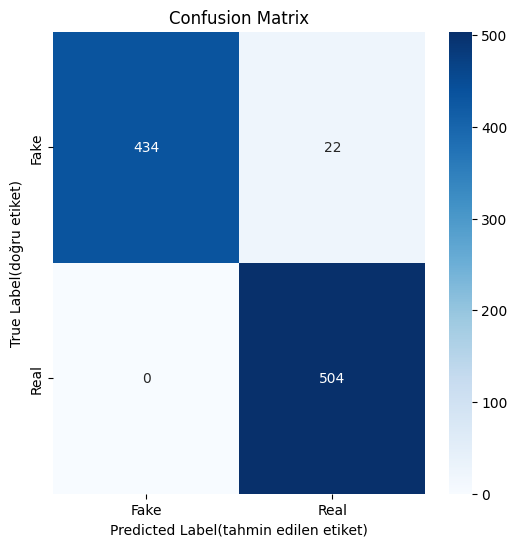

Classification Report:
               precision    recall  f1-score   support

        Fake       1.00      0.95      0.98       456
        Real       0.96      1.00      0.98       504

    accuracy                           0.98       960
   macro avg       0.98      0.98      0.98       960
weighted avg       0.98      0.98      0.98       960

Doğruluk Oranı: 97.71%
Fake Haberler İçin:
 Recall: 1.00, F1-Score: 0.98
Real Haberler İçin:
 Recall: 1.00, F1-Score: 0.98


'\n\nClassification Report:\n               precision    recall  f1-score   support\n\n        Fake       1.00      0.96      0.98       456\n        Real       0.96      1.00      0.98       504\n\n    accuracy                           0.98       960\n   macro avg       0.98      0.98      0.98       960\nweighted avg       0.98      0.98      0.98       960\n\nDoğruluk Oranı: 97.92%\nFake Haberler İçin:\n Recall: 1.00, F1-Score: 0.98\nReal Haberler İçin:\n Recall: 1.00, F1-Score: 0.98\n\n\n\n'

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertConfig, DistilBertTokenizer, AutoModelForSequenceClassification
from torch.optim import Adam
import os
import random
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import utils
# Config dosyasını ve eğitilmiş modeli yükleme
config_path = '/content/drive/MyDrive/collab1/DOSYALAR/fine_tuned_modelhoca/config.json'
model_path = '/content/drive/MyDrive/collab1/DOSYALAR/fine_tuned_modelhoca'

model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
config = DistilBertConfig.from_json_file(config_path)



class CustomModel(nn.Module):
    def __init__(self, pretrained_model, num_labels=2, dropout_rate=0.5):
        super(CustomModel, self).__init__()
        self.pretrained_model = pretrained_model

        # Son çıkış katmanı
        self.final_layer = nn.Linear(self.pretrained_model.config.hidden_size, num_labels)

        # Dropout eklenerek aşırı uydurmayı önlemek için yaptım
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask):
      outputs = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)

      # logits özelliğini doğrudan kullandım
      logits = outputs.logits



      return logits





# Özel modeli oluşturma
custom_model = CustomModel(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
custom_model.to(device)

# Optimizer ve loss fonksiyonu kısmı
optimizer = Adam(custom_model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

# Tokenizer'ı yükleme
tokenizer = DistilBertTokenizer.from_pretrained('dbmdz/distilbert-base-turkish-cased', truncation=True, padding=True)

# Fake ve Real haber veri seti yollarını verme kısmı
fake_folder_path = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/10-test/fake'
real_folder_path = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/10-test/real'

# Dosyaları karıştırdım
fake_files = [file for file in os.listdir(fake_folder_path) if file.endswith('.txt')]
real_files = [file for file in os.listdir(real_folder_path) if file.endswith('.txt')]
random.shuffle(fake_files)
random.shuffle(real_files)

# Doğrulama döngüsü - Her iki haber seti de kullanılacak şekilde
true_labels = []
predicted_labels = []

for file_name in fake_files + real_files:
    file_path = os.path.join(fake_folder_path, file_name) if file_name in fake_files else os.path.join(real_folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()

    # Dosya içeriğini tokenize etme
    inputs = tokenizer(file_content, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Modeli kullanarak tahmin yapma
    predictions = custom_model(**inputs)

    # Etiketi belirleme
    label = 0 if file_name in fake_files else 1

    # Tahmin ve gerçek etiketleri listeye ekleme
    true_labels.append(label)
    predicted_labels.append(torch.argmax(predictions, dim=1).item())

# Confusion matrix'i oluşturma
cm = confusion_matrix(true_labels, predicted_labels)

# Matrisi görselleştir
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label(tahmin edilen etiket)")
plt.ylabel("True Label(doğru etiket)")
plt.show()

# Classification report'u yazdır
class_report = classification_report(true_labels, predicted_labels, target_names=['Fake', 'Real'])
print("Classification Report:\n", class_report)

# Doğruluk oranını hesapla
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Doğruluk Oranı: {accuracy * 100:.2f}%")

# Recall, Precision ve F1-Score'u ayrı ayrı yazdır
precision_fake, recall_fake, f1_score_fake, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=[0], average='binary')
precision_real, recall_real, f1_score_real, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=[1], average='binary')

print(f"Fake Haberler İçin:\n Recall: {recall_fake:.2f}, F1-Score: {f1_score_fake:.2f}")
print(f"Real Haberler İçin:\n Recall: {recall_real:.2f}, F1-Score: {f1_score_real:.2f}")

'''

Classification Report:
               precision    recall  f1-score   support

        Fake       1.00      0.96      0.98       456
        Real       0.96      1.00      0.98       504

    accuracy                           0.98       960
   macro avg       0.98      0.98      0.98       960
weighted avg       0.98      0.98      0.98       960

Doğruluk Oranı: 97.92%
Fake Haberler İçin:
 Recall: 1.00, F1-Score: 0.98
Real Haberler İçin:
 Recall: 1.00, F1-Score: 0.98



'''


İKİNCİ EPOCH SAYISI ARTMIŞ  =>TEST GENEL LOSS

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Ortalama Test Loss: 0.1176


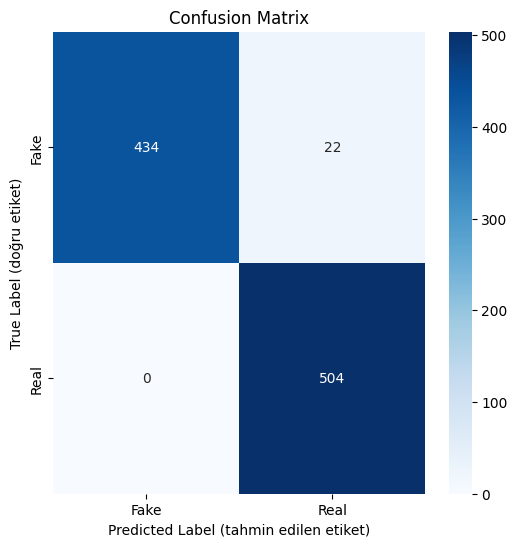

Classification Report:
               precision    recall  f1-score   support

        Fake       1.00      0.95      0.98       456
        Real       0.96      1.00      0.98       504

    accuracy                           0.98       960
   macro avg       0.98      0.98      0.98       960
weighted avg       0.98      0.98      0.98       960

Doğruluk Oranı: 97.71%

Fake Haberler İçin:
Precision: 0.9582
Recall: 1.0000
F1-Score: 0.9786

Real Haberler İçin:
Precision: 0.9582
Recall: 1.0000
F1-Score: 0.9786


In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertConfig, DistilBertTokenizer, AutoModelForSequenceClassification
from torch.optim import Adam
import os
import random
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import utils

# Config dosyasını ve eğitilmiş modeli yükleme
config_path = '/content/drive/MyDrive/collab1/DOSYALAR/fine_tuned_modelhoca/config.json'
model_path = '/content/drive/MyDrive/collab1/DOSYALAR/fine_tuned_modelhoca'

model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
config = DistilBertConfig.from_json_file(config_path)

class CustomModel(nn.Module):
    def __init__(self, pretrained_model, num_labels=2, dropout_rate=0.5):
        super(CustomModel, self).__init__()
        self.pretrained_model = pretrained_model
        self.final_layer = nn.Linear(self.pretrained_model.config.hidden_size, num_labels)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask):
        outputs = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        return logits

# Özel modeli oluşturma ve cihaza taşıma
custom_model = CustomModel(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
custom_model.to(device)

# Optimizer ve loss fonksiyonu
optimizer = Adam(custom_model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

# Tokenizer'ı yükleme
tokenizer = DistilBertTokenizer.from_pretrained('dbmdz/distilbert-base-turkish-cased', truncation=True, padding=True)

# Veri seti yolları
fake_folder_path = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/10-test/fake'
real_folder_path = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/10-test/real'

# Dosyaları yükleme ve karıştırma
fake_files = [file for file in os.listdir(fake_folder_path) if file.endswith('.txt')]
real_files = [file for file in os.listdir(real_folder_path) if file.endswith('.txt')]
random.shuffle(fake_files)
random.shuffle(real_files)

# Test işlemi
true_labels = []
predicted_labels = []
total_loss = 0
num_samples = 0

custom_model.eval()  # Modeli değerlendirme moduna al
with torch.no_grad():  # Gradyanları devre dışı bırak
    for file_name in fake_files + real_files:
        file_path = os.path.join(fake_folder_path, file_name) if file_name in fake_files else os.path.join(real_folder_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            file_content = file.read()

        # Dosya içeriğini tokenize etme
        inputs = tokenizer(file_content, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Gerçek etiketi belirleme ve tensor'e çevirme
        label = 0 if file_name in fake_files else 1
        label_tensor = torch.tensor([label]).to(device)

        # Modeli kullanarak tahmin yapma
        predictions = custom_model(**inputs)

        # Loss hesaplama
        batch_loss = loss_function(predictions, label_tensor)
        total_loss += batch_loss.item()
        num_samples += 1

        # Tahmin ve gerçek etiketleri listeye ekleme
        true_labels.append(label)
        predicted_labels.append(torch.argmax(predictions, dim=1).item())

# Ortalama loss hesaplama
average_loss = total_loss / num_samples
print(f"Ortalama Test Loss: {average_loss:.4f}")

# Confusion matrix oluşturma
cm = confusion_matrix(true_labels, predicted_labels)

# Confusion matrix görselleştirme
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label (tahmin edilen etiket)")
plt.ylabel("True Label (doğru etiket)")
plt.show()

# Sınıflandırma raporu
class_report = classification_report(true_labels, predicted_labels, target_names=['Fake', 'Real'])
print("Classification Report:\n", class_report)

# Doğruluk oranı hesaplama
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Doğruluk Oranı: {accuracy * 100:.2f}%")

# Recall, Precision ve F1-Score hesaplama ve yazdırma
precision_fake, recall_fake, f1_score_fake, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=[0], average='binary')
precision_real, recall_real, f1_score_real, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=[1], average='binary')

print(f"\nFake Haberler İçin:")
print(f"Precision: {precision_fake:.4f}")
print(f"Recall: {recall_fake:.4f}")
print(f"F1-Score: {f1_score_fake:.4f}")

print(f"\nReal Haberler İçin:")
print(f"Precision: {precision_real:.4f}")
print(f"Recall: {recall_real:.4f}")
print(f"F1-Score: {f1_score_real:.4f}")

# İLK CONFUSİON MATRİS İÇİN XX.XX%

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/410 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


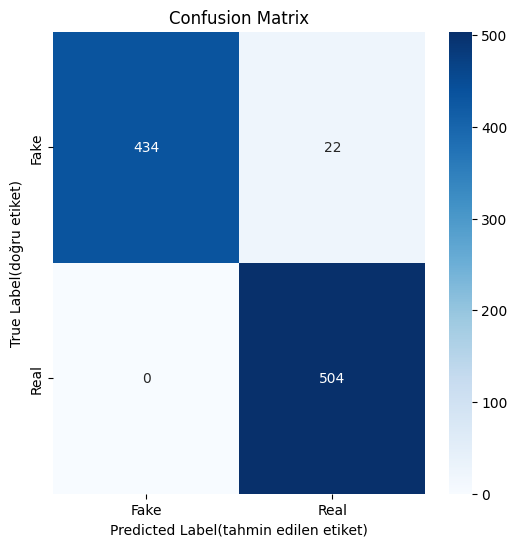

Classification Report:
               precision    recall  f1-score   support

        Fake       1.00      0.95      0.98       456
        Real       0.96      1.00      0.98       504

    accuracy                           0.98       960
   macro avg       0.98      0.98      0.98       960
weighted avg       0.98      0.98      0.98       960

Doğruluk Oranı: 97.71%
Fake Haberler İçin:
 Recall: 100.00%, F1-Score: 97.86%
Real Haberler İçin:
 Recall: 100.00%, F1-Score: 97.86%
Genel Performans:
 Precision: 95.82%, Recall: 100.00%, F1-Score: 97.86%


In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertConfig, DistilBertTokenizer, AutoModelForSequenceClassification
from torch.optim import Adam
import os
import random
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import utils

# Config dosyasını ve eğitilmiş modeli yükleme
config_path = '/content/drive/MyDrive/collab1/DOSYALAR/fine_tuned_modelhoca/config.json'
model_path = '/content/drive/MyDrive/collab1/DOSYALAR/fine_tuned_modelhoca'

model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
config = DistilBertConfig.from_json_file(config_path)

class CustomModel(nn.Module):
    def __init__(self, pretrained_model, num_labels=2, dropout_rate=0.5):
        super(CustomModel, self).__init__()
        self.pretrained_model = pretrained_model

        # Son çıkış katmanı
        self.final_layer = nn.Linear(self.pretrained_model.config.hidden_size, num_labels)

        # Dropout eklenerek aşırı uydurmayı önlemek için yaptım
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask):
        outputs = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)

        # logits özelliğini doğrudan kullandım
        logits = outputs.logits

        return logits

# Özel modeli oluşturma
custom_model = CustomModel(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
custom_model.to(device)

# Optimizer ve loss fonksiyonu kısmı
optimizer = Adam(custom_model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

# Tokenizer'ı yükleme
tokenizer = DistilBertTokenizer.from_pretrained('dbmdz/distilbert-base-turkish-cased', truncation=True, padding=True)

# Fake ve Real haber veri seti yollarını verme kısmı
fake_folder_path = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/10-test/fake'
real_folder_path = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/10-test/real'

# Dosyaları karıştırdım
fake_files = [file for file in os.listdir(fake_folder_path) if file.endswith('.txt')]
real_files = [file for file in os.listdir(real_folder_path) if file.endswith('.txt')]
random.shuffle(fake_files)
random.shuffle(real_files)

# Doğrulama döngüsü - Her iki haber seti de kullanılacak şekilde
true_labels = []
predicted_labels = []

for file_name in fake_files + real_files:
    file_path = os.path.join(fake_folder_path, file_name) if file_name in fake_files else os.path.join(real_folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()

    # Dosya içeriğini tokenize etme
    inputs = tokenizer(file_content, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Modeli kullanarak tahmin yapma
    predictions = custom_model(**inputs)

    # Etiketi belirleme
    label = 0 if file_name in fake_files else 1

    # Tahmin ve gerçek etiketleri listeye ekleme
    true_labels.append(label)
    predicted_labels.append(torch.argmax(predictions, dim=1).item())

# Confusion matrix'i oluşturma
cm = confusion_matrix(true_labels, predicted_labels)

# Matrisi görselleştir
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label(tahmin edilen etiket)")
plt.ylabel("True Label(doğru etiket)")
plt.show()

# Classification report'u yazdır
class_report = classification_report(true_labels, predicted_labels, target_names=['Fake', 'Real'])
print("Classification Report:\n", class_report)

# Doğruluk oranını hesapla
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Doğruluk Oranı: {accuracy * 100:.2f}%")

# Recall, Precision ve F1-Score'u ayrı ayrı yazdır
precision_fake, recall_fake, f1_score_fake, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=[0], average='binary')
precision_real, recall_real, f1_score_real, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=[1], average='binary')

# Yüzde formatında yazdırma
print(f"Fake Haberler İçin:\n Recall: {recall_fake * 100:.2f}%, F1-Score: {f1_score_fake * 100:.2f}%")
print(f"Real Haberler İçin:\n Recall: {recall_real * 100:.2f}%, F1-Score: {f1_score_real * 100:.2f}%")

# Genel performans metriklerini yüzde formatında yazdırma
precision_macro = np.mean([precision_fake, precision_real]) * 100
recall_macro = np.mean([recall_fake, recall_real]) * 100
f1_score_macro = np.mean([f1_score_fake, f1_score_real]) * 100

print(f"Genel Performans:\n Precision: {precision_macro:.2f}%, Recall: {recall_macro:.2f}%, F1-Score: {f1_score_macro:.2f}%")


# # İKİNCİ CONFUSİON MATRİS İÇİN XX.XX%

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Ortalama Test Loss: 0.1176


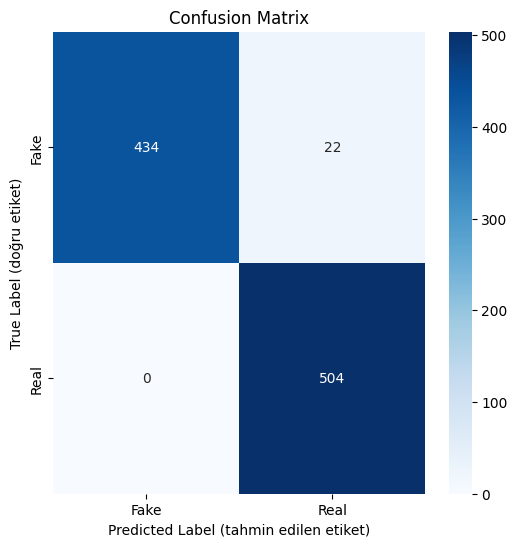


Fake Haberler İçin:
Precision: 95.82%
Recall: 100.00%
F1-Score: 97.86%

Real Haberler İçin:
Precision: 95.82%
Recall: 100.00%
F1-Score: 97.86%

Özel Sınıflandırma Raporu:
                Precision       Recall          F1-Score        Support        
0               100.00%         95.18%          97.53%          456            
1               95.82%          100.00%         97.86%          504            


In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertConfig, DistilBertTokenizer, AutoModelForSequenceClassification
from torch.optim import Adam
import os
import random
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Config dosyasını ve eğitilmiş modeli yükleme
config_path = '/content/drive/MyDrive/collab1/DOSYALAR/fine_tuned_modelhoca/config.json'
model_path = '/content/drive/MyDrive/collab1/DOSYALAR/fine_tuned_modelhoca'

model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
config = DistilBertConfig.from_json_file(config_path)

class CustomModel(nn.Module):
    def __init__(self, pretrained_model, num_labels=2, dropout_rate=0.5):
        super(CustomModel, self).__init__()
        self.pretrained_model = pretrained_model
        self.final_layer = nn.Linear(self.pretrained_model.config.hidden_size, num_labels)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask):
        outputs = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        return logits

# Özel modeli oluşturma ve cihaza taşıma
custom_model = CustomModel(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
custom_model.to(device)

# Optimizer ve loss fonksiyonu
optimizer = Adam(custom_model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

# Tokenizer'ı yükleme
tokenizer = DistilBertTokenizer.from_pretrained('dbmdz/distilbert-base-turkish-cased', truncation=True, padding=True)

# Veri seti yolları
fake_folder_path = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/10-test/fake'
real_folder_path = '/content/drive/MyDrive/collab1/DOSYALAR/SON_DATASET/random10_90(960-8756)/10-test/real'

# Dosyaları yükleme ve karıştırma
fake_files = [file for file in os.listdir(fake_folder_path) if file.endswith('.txt')]
real_files = [file for file in os.listdir(real_folder_path) if file.endswith('.txt')]
random.shuffle(fake_files)
random.shuffle(real_files)

# Test işlemi
true_labels = []
predicted_labels = []
total_loss = 0
num_samples = 0

custom_model.eval()  # Modeli değerlendirme moduna al
with torch.no_grad():  # Gradyanları devre dışı bırak
    for file_name in fake_files + real_files:
        file_path = os.path.join(fake_folder_path, file_name) if file_name in fake_files else os.path.join(real_folder_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            file_content = file.read()

        # Dosya içeriğini tokenize etme
        inputs = tokenizer(file_content, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Gerçek etiketi belirleme ve tensor'e çevirme
        label = 0 if file_name in fake_files else 1
        label_tensor = torch.tensor([label]).to(device)

        # Modeli kullanarak tahmin yapma
        predictions = custom_model(**inputs)

        # Loss hesaplama
        batch_loss = loss_function(predictions, label_tensor)
        total_loss += batch_loss.item()
        num_samples += 1

        # Tahmin ve gerçek etiketleri listeye ekleme
        true_labels.append(label)
        predicted_labels.append(torch.argmax(predictions, dim=1).item())

# Ortalama loss hesaplama
average_loss = total_loss / num_samples
print(f"Ortalama Test Loss: {average_loss:.4f}")

# Confusion matrix oluşturma
cm = confusion_matrix(true_labels, predicted_labels)

# Confusion matrix görselleştirme
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label (tahmin edilen etiket)")
plt.ylabel("True Label (doğru etiket)")
plt.show()

# Sınıflandırma raporu
precision_fake, recall_fake, f1_score_fake, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=[0], average='binary')
precision_real, recall_real, f1_score_real, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=[1], average='binary')

# Yüzde formatında yazdırma
print(f"\nFake Haberler İçin:")
print(f"Precision: {precision_fake * 100:.2f}%")
print(f"Recall: {recall_fake * 100:.2f}%")
print(f"F1-Score: {f1_score_fake * 100:.2f}%")

print(f"\nReal Haberler İçin:")
print(f"Precision: {precision_real * 100:.2f}%")
print(f"Recall: {recall_real * 100:.2f}%")
print(f"F1-Score: {f1_score_real * 100:.2f}%")

# Sınıflandırma raporunu yüzde formatında yazdırma
def custom_classification_report(true_labels, predicted_labels):
    precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, predicted_labels)

    report = {
        'Precision': [f"{p * 100:.2f}%" for p in precision],
        'Recall': [f"{r * 100:.2f}%" for r in recall],
        'F1-Score': [f"{f * 100:.2f}%" for f in f1_score],
        'Support': support
    }

    print("\nÖzel Sınıflandırma Raporu:")
    print(f"{'':<15} {'Precision':<15} {'Recall':<15} {'F1-Score':<15} {'Support':<15}")
    for i in range(len(report['Precision'])):
        print(f"{i:<15} {report['Precision'][i]:<15} {report['Recall'][i]:<15} {report['F1-Score'][i]:<15} {report['Support'][i]:<15}")

# Özel sınıflandırma raporunu çağır
custom_classification_report(true_labels, predicted_labels)
